In [1]:
import os, sys
sys.path.insert(0, os.path.join(".."))

# San Francisco street centre lines into graph

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.collections
import numpy as np
import bz2
import tilemapbase

import opencrimedata.san_francisco
import opencrimedata.geometry
import opencrimedata.tiger_lines

In [3]:
datadir = os.path.join("..", "..", "..", "..", "Data")
#datadir = os.path.join("/media", "disk", "Data")

filename = os.path.join(datadir, "San Francisco Basemap Street Centerlines")
def stgen():
    yield from opencrimedata.san_francisco.load_street_centre_lines(filename)

In [4]:
next(stgen())

Street(street_id=15145000, layer='PRIVATE', nhood='Twin Peaks', oneway='B', name='CROWN CT', left=None, right=None, line=array([[-122.44694245,   37.75722892],
       [-122.44664129,   37.7572054 ],
       [-122.44586702,   37.75693649]]))

In [5]:
opencrimedata.san_francisco.street_layer_accept(next(stgen()))

True

In [6]:
def gen_streets():
    for row in stgen():
        if opencrimedata.san_francisco.street_layer_accept(row):
            yield row

In [7]:
next(gen_streets())

Street(street_id=15145000, layer='PRIVATE', nhood='Twin Peaks', oneway='B', name='CROWN CT', left=None, right=None, line=array([[-122.44694245,   37.75722892],
       [-122.44664129,   37.7572054 ],
       [-122.44586702,   37.75693649]]))

## Form graph

In [8]:
proj = opencrimedata.san_francisco.projector()

def proj_street(street):
    line = np.asarray(street.line)
    return np.asarray(proj(*line.T)).T

graph, names = opencrimedata.geometry.graph_from_streets(gen_streets(), proj_street)

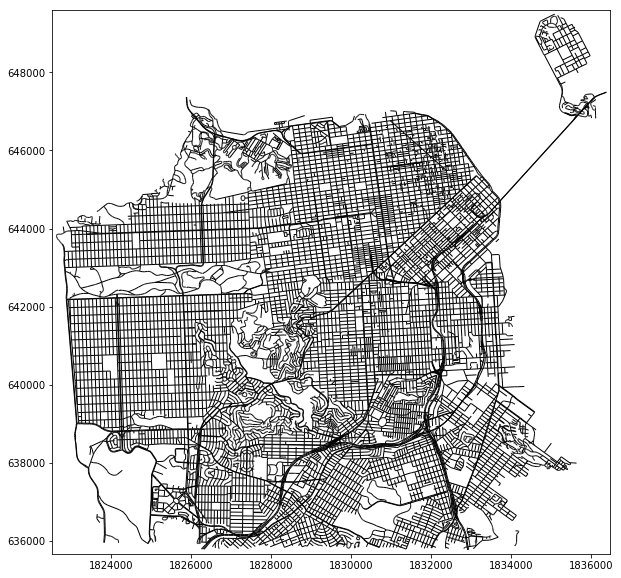

In [9]:
fig, ax = plt.subplots(figsize=(10,10))

lines = graph.as_lines()
lines = matplotlib.collections.LineCollection(lines, linewidth=1, color="black")
ax.add_collection(lines)

d = 100
xmin, ymin, xmax, ymax = graph.bounds
ax.set(xlim=[xmin-d, xmax+d], ylim=[ymin-d, ymax+d])
None

## Do crime events match up with network??

In [10]:
def gen():
    filename = os.path.join(datadir, "SF_Police_Department_Incidents.csv.bz2")
    with bz2.open(filename, "rt", encoding="UTF8") as f:
        yield from opencrimedata.san_francisco.load(f)

next(gen())

Row(category='NON-CRIMINAL', description='LOST PROPERTY', datetime=datetime.datetime(2015, 1, 19, 14, 0), block='18TH ST / VALENCIA ST', point=(-122.42158168137, 37.7617007179518), idd='15006027571000', incident='150060275')

In [11]:
rows = list(gen())
len(rows)

2119901

In [12]:
distances = []
points_on_streets = []
for row in rows:
    x, y = proj(*row.point)
    edge, t = graph.project_point_to_graph(x, y)
    xx, yy = graph.edge_to_coords(*edge, t)
    points_on_streets.append((xx, yy))
    d = np.sqrt((xx-x)**2 + (yy-y)**2)
    distances.append(d)
distances = np.asarray(distances)
points_on_streets = np.asarray(points_on_streets)

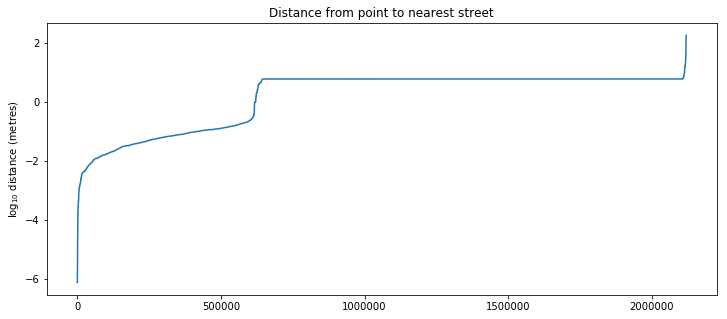

In [13]:
d = np.sort(distances)
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(np.log10(d))
ax.set_title("Distance from point to nearest street")
ax.set(ylabel="$\log_{10}$ distance (metres)")
None

In [14]:
wm_points = np.asarray([tilemapbase.project(*row.point) for row in rows])
wm_points.shape

(2119901, 2)

In [15]:
wm_points_on_streets = np.asarray([tilemapbase.project(*proj(*pt, inverse=True)) for pt in points_on_streets])
wm_points_on_streets.shape

(2119901, 2)

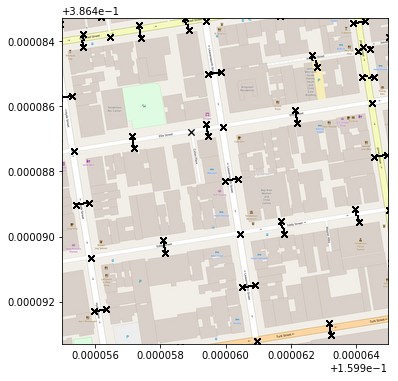

In [16]:
fig, ax = plt.subplots(figsize=(6,6))

i = np.where(distances > 6)[0][0]
x, y = rows[i].point

ex = tilemapbase.Extent.from_centre_lonlat(x, y, xsize=0.00001)
plotter = tilemapbase.Plotter(ex, tilemapbase.tiles.OSM, width=800)
plotter.plot(ax)
ax.scatter(*wm_points.T, marker="x", color="black", linewidth=1)

lines = []
for pt1, pt2 in zip(wm_points, wm_points_on_streets):
    lines.append((pt1, pt2))
l = matplotlib.collections.LineCollection(lines, linewidth=1, color="black")
ax.add_collection(l)

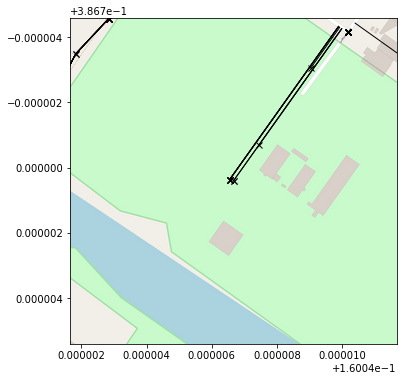

In [17]:
fig, ax = plt.subplots(figsize=(6,6))

i = np.where(distances > 180)[0][0]
x, y = rows[i].point

ex = tilemapbase.Extent.from_centre_lonlat(x, y, xsize=0.00001)
plotter = tilemapbase.Plotter(ex, tilemapbase.tiles.OSM, width=800)
plotter.plot(ax)
ax.scatter(*wm_points.T, marker="x", color="black", linewidth=1)

lines = []
for pt1, pt2 in zip(wm_points, wm_points_on_streets):
    lines.append((pt1, pt2))
l = matplotlib.collections.LineCollection(lines, linewidth=1, color="black")
ax.add_collection(l)

## Same with TIGER/Lines data

In [18]:
tigerdir = os.path.join("..", "..", "..", "..", "Data", "TIGER Data")
#tigerdir = os.path.join("/media", "disk", "TIGER Data")

tiger_lines = opencrimedata.tiger_lines.TigerLines(
    os.path.join(tigerdir, "tl_2016_06075_roads__san_francisco"),
    os.path.join(tigerdir, "tl_2016_06075_edges__san_francisco"),
    opencrimedata.san_francisco.projector())

In [19]:
graph, edge_list = tiger_lines.make_reduced_graph()

In [20]:
data = []
for row in gen():
    x, y = proj(*row.point)
    edge, t = graph.project_point_to_graph(x, y)
    xx, yy = graph.edge_to_coords(*edge, t)
    data.append((row, (xx, yy)))
len(data)

2119901

In [21]:
distances = []
for row, pt in data:
    x, y = proj(*row.point)
    d = np.sqrt((pt[0] - x)**2 + (pt[1] - y)**2)
    distances.append(d)
distances = np.asarray(distances)

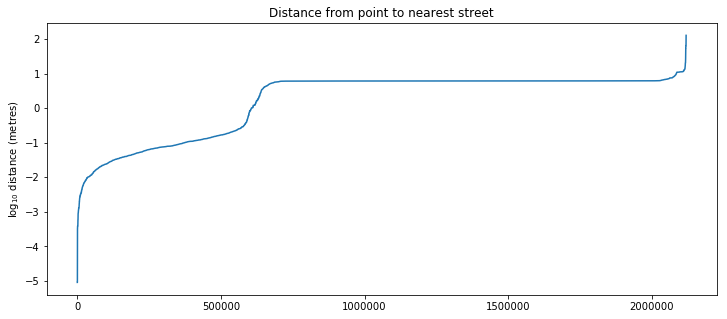

In [22]:
d = np.sort(distances)
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(np.log10(d))
ax.set_title("Distance from point to nearest street")
ax.set(ylabel="$\log_{10}$ distance (metres)")
None

In [23]:
wm_points = np.asarray([tilemapbase.project(*row.point) for row, _ in data])
wm_points_on_streets = np.asarray([tilemapbase.project(*proj(*pt, inverse=True)) for _, pt in data])

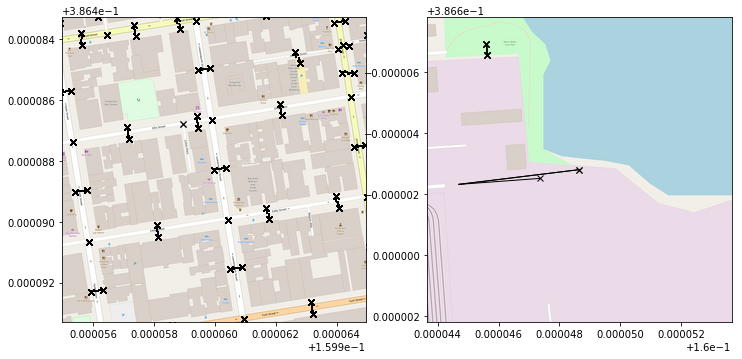

In [24]:
fig, axes = plt.subplots(ncols=2, figsize=(12,6))

i = np.where(distances > 6)[0][0]
x, y = data[i][0].point
ex = tilemapbase.Extent.from_centre_lonlat(x, y, xsize=0.00001)
plotter = tilemapbase.Plotter(ex, tilemapbase.tiles.OSM, width=800)
plotter.plot(axes[0])

i = np.where(distances > 120)[0][0]
x, y = data[i][0].point
ex = tilemapbase.Extent.from_centre_lonlat(x, y, xsize=0.00001)
plotter = tilemapbase.Plotter(ex, tilemapbase.tiles.OSM, width=800)
plotter.plot(axes[1])

for ax in axes:
    ax.scatter(*wm_points.T, marker="x", color="black", linewidth=1)
    lines = []
    for pt1, pt2 in zip(wm_points, wm_points_on_streets):
        lines.append((pt1, pt2))
    l = matplotlib.collections.LineCollection(lines, linewidth=1, color="black")
    ax.add_collection(l)